In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
path = '/kaggle/input/store-sales-time-series-forecasting/'
os.listdir(path)

['oil.csv',
 'sample_submission.csv',
 'holidays_events.csv',
 'stores.csv',
 'train.csv',
 'test.csv',
 'transactions.csv']

In [3]:
df_sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')
print(df_sample.head())
print(df_sample.shape)

        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0
(28512, 2)


In [4]:
# load files
df_train = pd.read_csv(path + 'train.csv', index_col = 0)
df_test = pd.read_csv(path + 'test.csv', index_col = 0)

df_holidays = pd.read_csv(path + 'holidays_events.csv')
df_oil = pd.read_csv(path + 'oil.csv')
df_stores = pd.read_csv(path + 'stores.csv')
df_trans = pd.read_csv(path + 'transactions.csv')

df_subm = pd.read_csv(path + 'sample_submission.csv')

In [5]:
# check dimensions of each file
print(f'Number of train_data samples: {df_train.shape}')
print(f'Number of test_data samples: {df_test.shape}')

print(f'Number of data_oil samples: {df_oil.shape}')
print(f'Number of data_holi samples: {df_holidays.shape}')
print(f'Number of data_store samples: {df_stores.shape}')
print(f'Number of data_trans samples: {df_trans.shape}')

print(f'Number of samp_subm samples: {df_subm.shape}')

Number of train_data samples: (3000888, 5)
Number of test_data samples: (28512, 4)
Number of data_oil samples: (1218, 2)
Number of data_holi samples: (350, 6)
Number of data_store samples: (54, 5)
Number of data_trans samples: (83488, 3)
Number of samp_subm samples: (28512, 2)


In [6]:
# check train data
print(df_train.head())
print(df_train.tail())

          date  store_nbr      family  sales  onpromotion
id                                                       
0   2013-01-01          1  AUTOMOTIVE    0.0            0
1   2013-01-01          1   BABY CARE    0.0            0
2   2013-01-01          1      BEAUTY    0.0            0
3   2013-01-01          1   BEVERAGES    0.0            0
4   2013-01-01          1       BOOKS    0.0            0
               date  store_nbr                      family     sales  \
id                                                                     
3000883  2017-08-15          9                     POULTRY   438.133   
3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
id                    
3000883            0  
3000884            1

In [9]:
print(df_train.groupby('date').nunique())

            store_nbr  family  sales  onpromotion
date                                             
2013-01-01         54      33     17            1
2013-01-02         54      33    568            1
2013-01-03         54      33    559            1
2013-01-04         54      33    553            1
2013-01-05         54      33    575            1
...               ...     ...    ...          ...
2017-08-11         54      33    786           73
2017-08-12         54      33    789           55
2017-08-13         54      33    765           67
2017-08-14         54      33    762           54
2017-08-15         54      33    762           75

[1684 rows x 4 columns]


In [10]:
# seems there is some missing date in the train set

grouped = df_train.groupby('date').sum()

# Create a complete date range
full_date_range = pd.date_range(start='2013-01-01', end='2017-08-15')
print(len(full_date_range))

# Find missing dates
present_dates = pd.to_datetime(grouped.index)
# print(present_dates)
missing_dates = pd.Index(full_date_range).difference(present_dates)

# Output missing dates
print("Missing Dates:")
print(missing_dates)
print(len(missing_dates))

# 4 days are missing: 12-25 for every year

1688
Missing Dates:
DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)
4


In [11]:
print(df_test.head())
print(df_test.tail())

               date  store_nbr      family  onpromotion
id                                                     
3000888  2017-08-16          1  AUTOMOTIVE            0
3000889  2017-08-16          1   BABY CARE            0
3000890  2017-08-16          1      BEAUTY            2
3000891  2017-08-16          1   BEVERAGES           20
3000892  2017-08-16          1       BOOKS            0
               date  store_nbr                      family  onpromotion
id                                                                     
3029395  2017-08-31          9                     POULTRY            1
3029396  2017-08-31          9              PREPARED FOODS            0
3029397  2017-08-31          9                     PRODUCE            1
3029398  2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
3029399  2017-08-31          9                     SEAFOOD            0


In [12]:
# seems there is some missing date in the train set

grouped = df_test.groupby('date').sum()

# Create a complete date range
full_date_range = pd.date_range(start='2017-08-16', end='2017-08-31')

# Find missing dates
present_dates = pd.to_datetime(grouped.index)
# print(present_dates)
missing_dates = pd.Index(full_date_range).difference(present_dates)

# Output missing dates
print("Missing Dates:")
print(missing_dates)
print(len(missing_dates))

# no missing dates for test

Missing Dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
0


In [13]:
print(df_trans.head())
print(df_trans.tail())

         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922
             date  store_nbr  transactions
83483  2017-08-15         50          2804
83484  2017-08-15         51          1573
83485  2017-08-15         52          2255
83486  2017-08-15         53           932
83487  2017-08-15         54           802


In [14]:
# check if there is any missing value
df_train.isnull().sum()
# no missing values

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

## Oil price dependency: Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [15]:
print(f"dimention of oil data: {df_oil.shape}")

dimention of oil data: (1218, 2)


In [16]:
print(df_oil.head())

         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20


In [17]:
# check empty data in oil
df_oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [18]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [19]:
# There should be 1703 days between 2013-01-01 and 2017-08-31
# But There are lots of missing values and 43 NaN values
len(df_oil.groupby("date").sum())

1218

In [20]:
len(df_oil[df_oil['dcoilwtico'].notnull()])
# 1218 (total numrows) = 1175 (rows with value) + 43 (NaN rows)

1175

In [21]:
df_oil[df_oil['dcoilwtico'] == 0]

,date,dcoilwtico


In [22]:
df_oil[df_oil["date"].isnull()]

,date,dcoilwtico


In [23]:
# sporadic oil missingg values
df_oil[df_oil["dcoilwtico"].isnull()]

,date,dcoilwtico
0,2013-01-01,NaN
14,2013-01-21,NaN
34,2013-02-18,NaN
63,2013-03-29,NaN
104,2013-05-27,NaN
132,2013-07-04,NaN
174,2013-09-02,NaN
237,2013-11-28,NaN
256,2013-12-25,NaN
261,2014-01-01,NaN


Text(0, 0.5, 'Oil price')

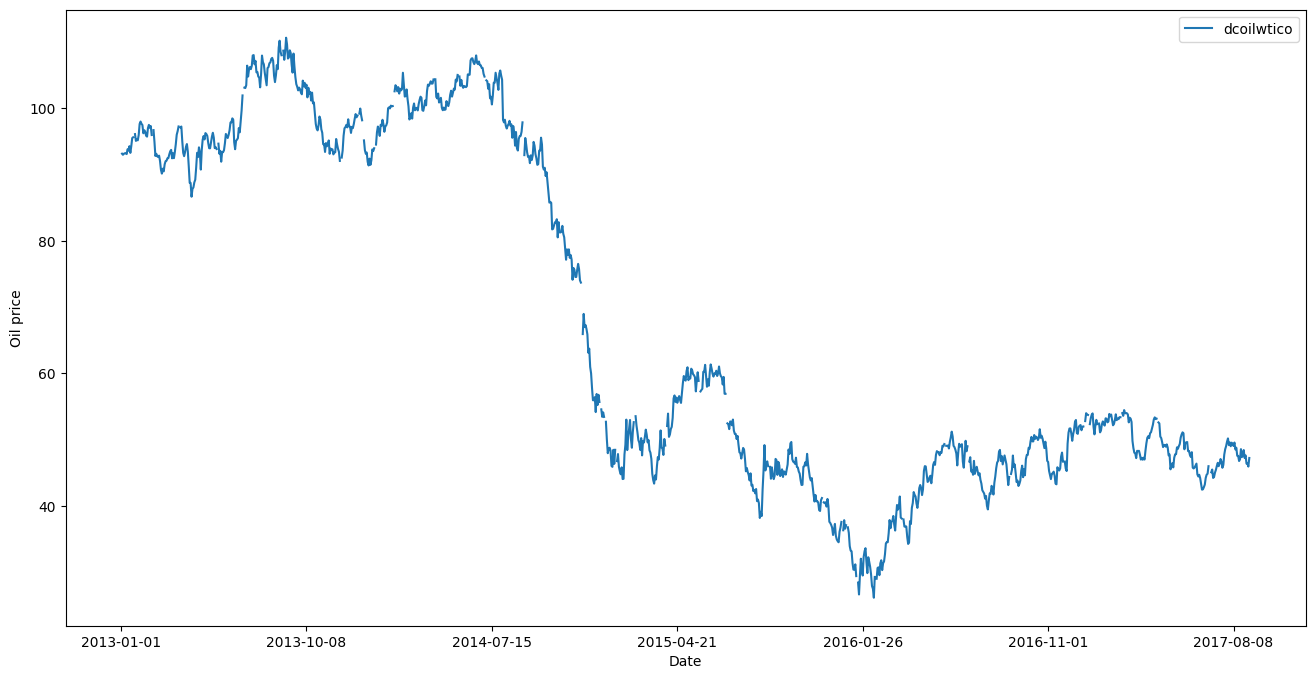

In [24]:
# oil data
ax = df_oil.set_index("date").plot(figsize = (16, 8))
ax.set_xlabel("Date")
ax.set_ylabel("Oil price")

In [25]:
# Import 
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
print(oil.shape)

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
print(oil.shape)

# Replace 0s with NaN
oil = oil.replace(0, np.nan)


(1218, 2)
(1704, 2)


In [26]:
# Import 
oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")
oil["date"] = pd.to_datetime(oil.date)
# print(oil.shape)

# print(oil['dcoilwtico'].isnull().sum())

# Fill the first missing value manually
# oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='bfill', limit=1)  # Backward fill the first NaN
# print(oil['dcoilwtico'].isnull().sum())

# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum()
# print(oil.shape)

# Replace 0s with NaN
oil = oil.replace(0, np.nan)

# Interpolate and reset index
oil_interpolated = oil.interpolate(method="time").reset_index()

# First value missing: back fill
oil_interpolated['dcoilwtico'] = oil_interpolated['dcoilwtico'].fillna(method='bfill') 

# reset oil index
oil = oil.reset_index()

# Reset index to bring 'date' back as a column
# oil = oil_interpolated.reset_index()
# oil_interpolated.reset_index()

/tmp/ipykernel_30/2334969432.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil_interpolated['dcoilwtico'] = oil_interpolated['dcoilwtico'].fillna(method='bfill')


In [27]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1704 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.8 KB


In [28]:
oil_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1704 non-null   datetime64[ns]
 1   dcoilwtico  1704 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.8 KB


In [29]:
oil_interpolated.head()

,date,dcoilwtico
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [30]:
oil.isnull().sum()

date            0
dcoilwtico    529
dtype: int64

In [31]:
oil_interpolated.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [32]:
oil_interpolated.columns

Index(['date', 'dcoilwtico'], dtype='object')

In [33]:
oil_interpolated.rename(columns={'dcoilwtico': 'dcoil_2'}, inplace=True)
oil_interpolated.head()

,date,dcoil_2
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [34]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN


In [35]:
import plotly.express as px

# Merge the DataFrames on the 'date' column
df_merged = pd.merge(oil, oil_interpolated, on='date')

# Melt the merged DataFrame for long format (needed for Plotly)
df_long = df_merged.melt(id_vars='date', 
                         value_vars=['dcoil_2', 'dcoilwtico'], 
                         var_name='Type', 
                         value_name='Value')

# Plot the time series
fig = px.line(df_long, x='date', y='Value', color='Type', 
              title='Original vs Interpolated Time Series',
              labels={'Value': 'Value', 'date': 'Date', 'Type': 'Series Type'},
                 color_discrete_map={
                    'dcoilwtico': 'blue',  # Original series in blue
                    'dcoil_2': 'red'   # Interpolated series in orange
                })

# fig.show()
fig.show(renderer='iframe')

## Does oil price actually affect sales?

In [36]:
df_train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [37]:
oil_interpolated.head()

,date,dcoil_2
0,2013-01-01,93.140000
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667


In [38]:
df_train.groupby("date")["sales"].sum()

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Name: sales, Length: 1684, dtype: float64

In [39]:
df = df_train.copy()

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by 'date' and sum sales
sales_per_date = df.groupby('date')['sales'].sum().reset_index()

# Rename columns for clarity (optional)
sales_per_date.rename(columns={'sales': 'total_sales'}, inplace=True)

print(sales_per_date)

           date    total_sales
0    2013-01-01    2511.618999
1    2013-01-02  496092.417944
2    2013-01-03  361461.231124
3    2013-01-04  354459.677093
4    2013-01-05  477350.121229
...         ...            ...
1679 2017-08-11  826373.722022
1680 2017-08-12  792630.535079
1681 2017-08-13  865639.677471
1682 2017-08-14  760922.406081
1683 2017-08-15  762661.935939

[1684 rows x 2 columns]


In [40]:
import plotly.graph_objects as go

# Calculate correlation
correlation = sales_per_date['total_sales'].corr(oil_interpolated['dcoil_2'])
print(f"Correlation between series1 and series2: {correlation:.2f}")


# Create Plotly figure
fig = go.Figure()

# Add Series 1
fig.add_trace(go.Scatter(x=sales_per_date['date'], y=sales_per_date['total_sales'], mode='lines+markers', name='Series 1'))

# Add Series 2
fig.add_trace(go.Scatter(x=oil_interpolated['date'], y=oil_interpolated['dcoil_2'], mode='lines+markers', name='Series 2'))

# Add title with correlation value
fig.update_layout(
    title=f'Time Series Plot (Correlation: {correlation:.2f})',
    xaxis_title='Date',
    yaxis_title='Values',
    legend_title='Series',
    template='plotly_white'
)

fig.show(renderer='iframe')

Correlation between series1 and series2: -0.63


In [41]:
# Merge the DataFrames on the 'date' column
merged_sales_oil = pd.merge(sales_per_date, oil_interpolated, on='date')

# Scatter plot with Plotly
fig = px.scatter(
    merged_sales_oil,
    x='dcoil_2',
    y='total_sales',
    title='Scatter Plot of oil vs sales',
    labels={'dcoil_2': 'oil', 'total_sales': 'sales'},
    template='plotly_white'
)

fig.show(renderer='iframe')

In [42]:
merged_sales_oil.shape

(1684, 3)

## Analize Sales

In [43]:
# Plot 
# There seems to be some trend
fig = px.line(
    sales_per_date,
    x='date',
    y='total_sales',
    title='Time Series Plot',
    labels={'date': 'Date', 'total_sales': 'Total Sales'},
    template='plotly_white'
)
fig.show(renderer='iframe')

In [44]:
sales_per_date.isnull().sum()

date           0
total_sales    0
dtype: int64

In [46]:
df_train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [59]:
print(df_train["store_nbr"].nunique())
print(df_train["family"].nunique())

54
33


In [60]:
54*33

1782

In [65]:
df_train.shape

(3000888, 5)

In [68]:
# some stores may not have some family which can lead to 0 sales

# Group by 'store_nbr' and 'family' and check if all sales are 0
sales_only_zero = df_train.groupby(['store_nbr', 'family'])['sales'].sum()

# Filter combinations where the total sales is 0
sales_only_zero = sales_only_zero[sales_only_zero == 0]

# Reset index to get the combinations as a DataFrame
result = sales_only_zero.reset_index()

print(result.shape)
print(result)

# seems many stores do not have books and baby care

(53, 3)
    store_nbr           family  sales
0           1        BABY CARE    0.0
1           9            BOOKS    0.0
2          10            BOOKS    0.0
3          11            BOOKS    0.0
4          12            BOOKS    0.0
5          13        BABY CARE    0.0
6          13            BOOKS    0.0
7          14            BOOKS    0.0
8          14  LAWN AND GARDEN    0.0
9          15            BOOKS    0.0
10         16            BOOKS    0.0
11         16       LADIESWEAR    0.0
12         17            BOOKS    0.0
13         18            BOOKS    0.0
14         19            BOOKS    0.0
15         20            BOOKS    0.0
16         21            BOOKS    0.0
17         22            BOOKS    0.0
18         23        BABY CARE    0.0
19         25       LADIESWEAR    0.0
20         28            BOOKS    0.0
21         28       LADIESWEAR    0.0
22         29            BOOKS    0.0
23         29       LADIESWEAR    0.0
24         30            BOOKS    0.0
25  

## check sales trend per week, month, and year

In [69]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year

In [71]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  int64         
 5   day_of_week  int32         
 6   month        int32         
 7   year         int32         
dtypes: datetime64[ns](1), float64(1), int32(3), int64(2), object(1)
memory usage: 171.7+ MB


/tmp/ipykernel_30/309403659.py:6: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



<Axes: title={'center': 'sales - year'}, xlabel='year'>

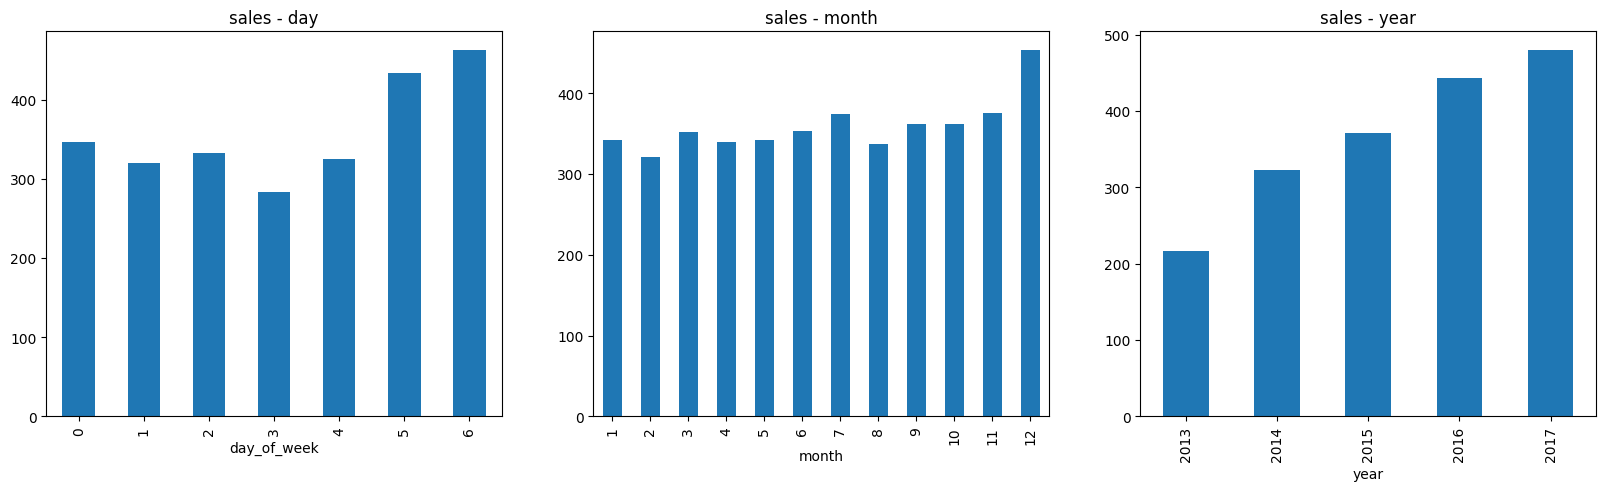

In [74]:
data_grouped_day = df_train.groupby(['day_of_week'])['sales'].mean()
data_grouped_month = df_train.groupby(['month'])['sales'].mean()
data_grouped_year = df_train.groupby(['year'])['sales'].mean()

plt.subplots(3,1, figsize=(20,5))
plt.subplot(131)
plt.title('sales - day')
data_grouped_day.plot(kind='bar', stacked=True)
plt.subplot(132)
plt.title('sales - month')
data_grouped_month.plot(kind='bar', stacked=True)
plt.subplot(133)
plt.title('sales - year')
data_grouped_year.plot(kind='bar', stacked=True)

# Holidays

In [76]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [83]:
df_holidays["type"].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [79]:
df_trans.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [30]:
df_transactions.head(-5)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83478,2017-08-15,45,3685
83479,2017-08-15,46,3197
83480,2017-08-15,47,3581
83481,2017-08-15,48,2722


In [21]:
df_transactions.shape

(83488, 3)

In [169]:
df_test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


In [170]:
df_train.head(-5)

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000878,2017-08-15,9,MAGAZINES,11.000,0
3000879,2017-08-15,9,MEATS,449.228,0
3000880,2017-08-15,9,PERSONAL CARE,522.000,11


# Following time series tutorial

## 1. Linear Regression with time series

In [5]:
df_train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [6]:
avg_sales = df_train.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales['Time'] = np.arange(len(avg_sales.index))
avg_sales.head()
# average sales per day

,date,sales,Time
0,2013-01-01,1.409438,0
1,2013-01-02,278.390807,1
2,2013-01-03,202.840197,2
3,2013-01-04,198.911154,3
4,2013-01-05,267.873244,4


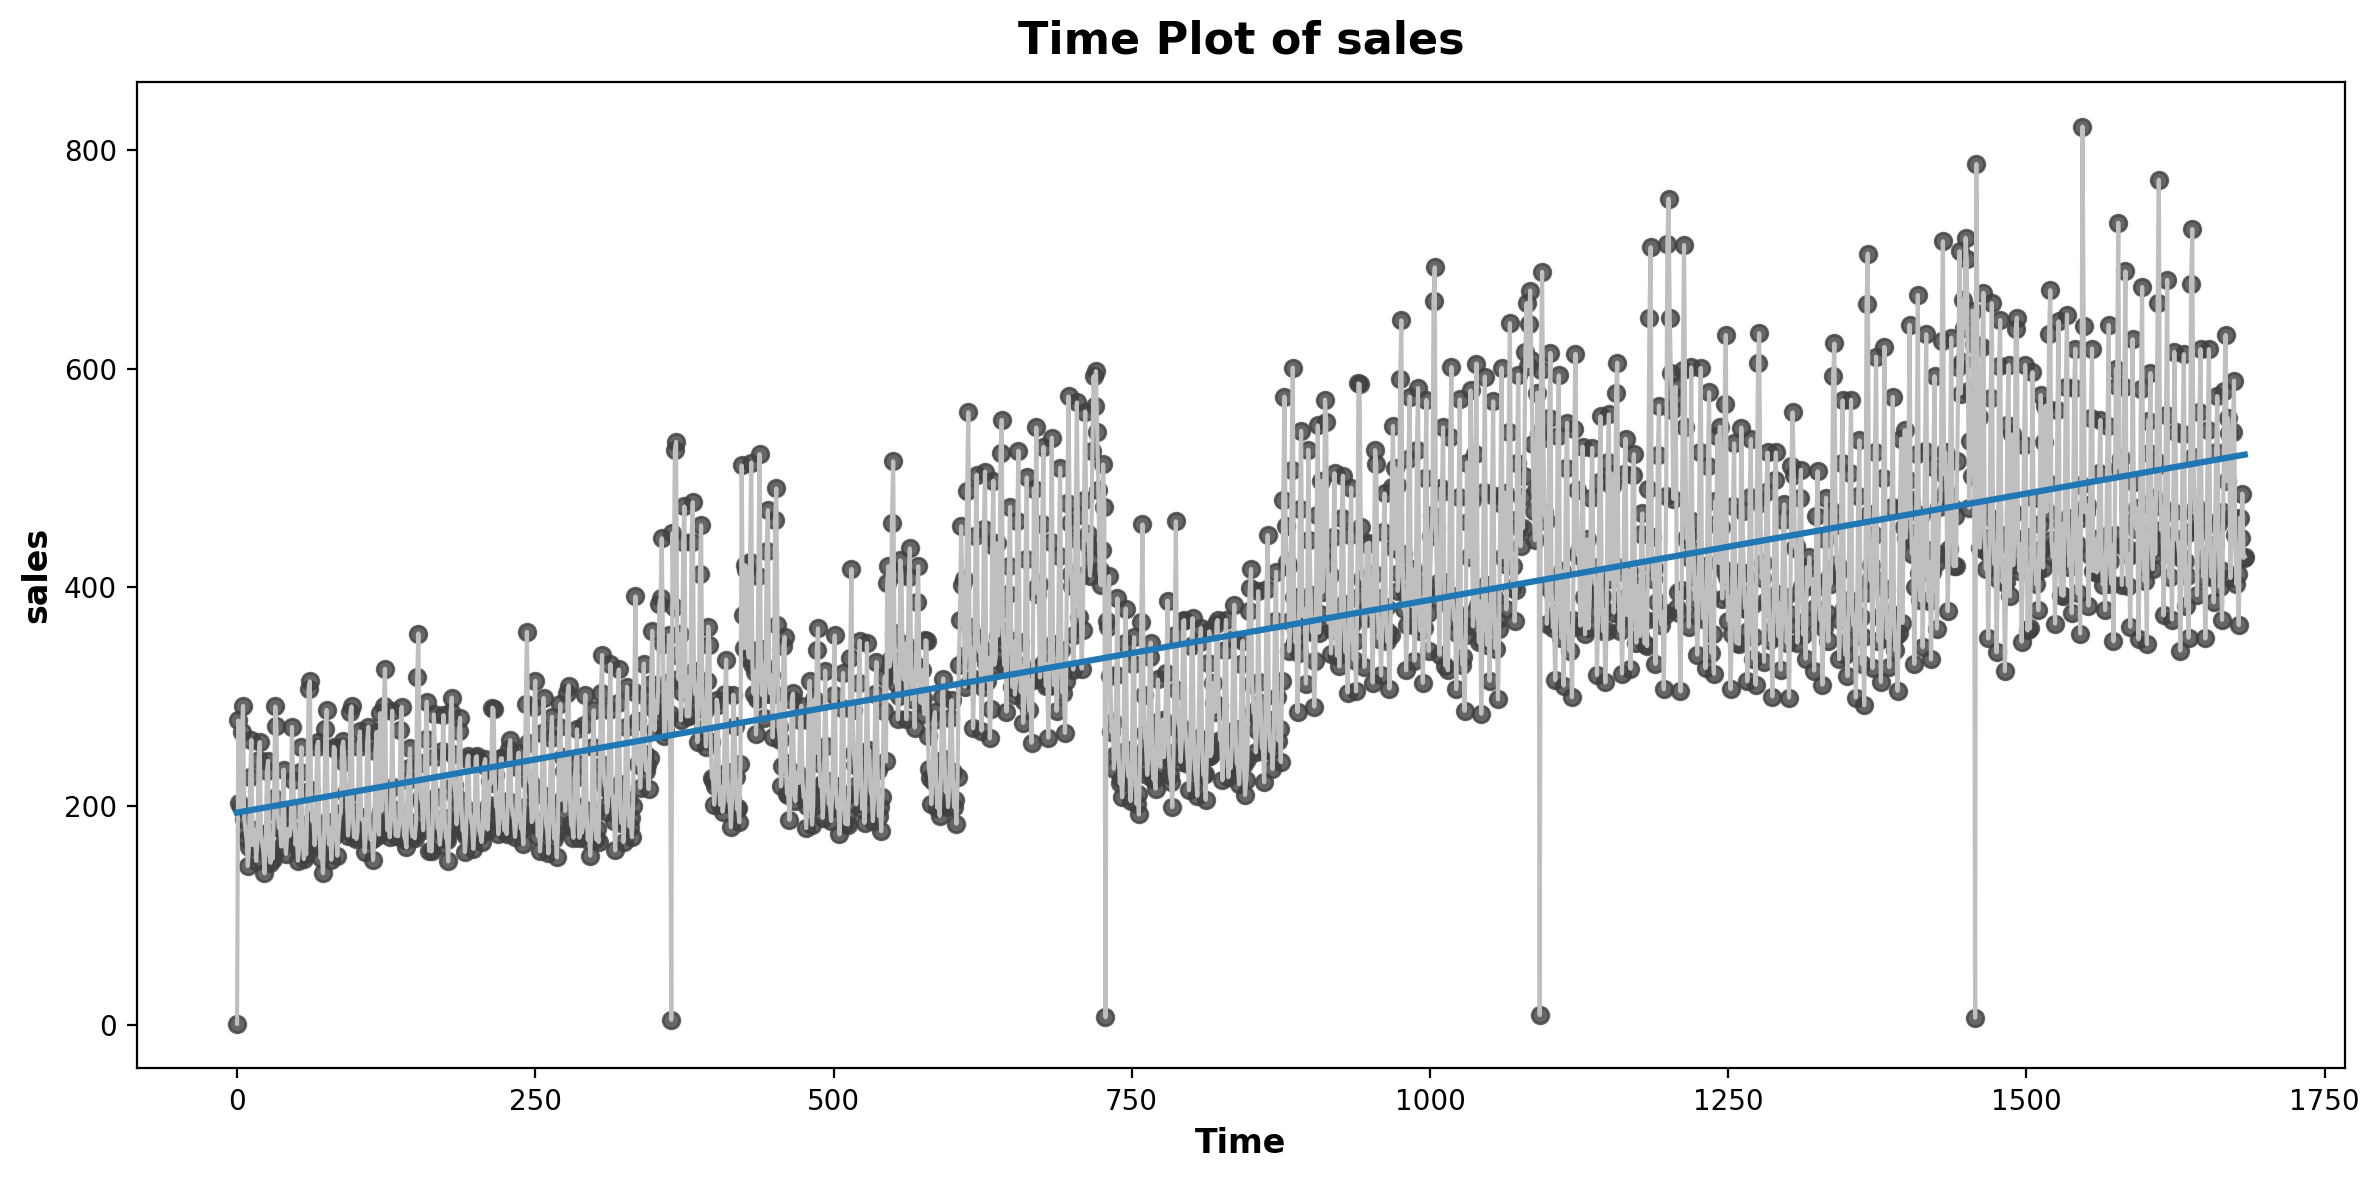

In [7]:
# time feature
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'sales', data=avg_sales, color='0.75')
ax = sns.regplot(x='Time', y='sales', data=avg_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of sales');

In [8]:
# Lag features
# target = weight * lag + bias

avg_sales['Lag_1'] = avg_sales['sales'].shift(1)
avg_sales = avg_sales.reindex(columns = ['date','sales', 'Lag_1','Time'])
avg_sales.head()

,date,sales,Lag_1,Time
0,2013-01-01,1.409438,NaN,0
1,2013-01-02,278.390807,1.409438,1
2,2013-01-03,202.840197,278.390807,2
3,2013-01-04,198.911154,202.840197,3
4,2013-01-05,267.873244,198.911154,4


Text(0.5, 1.0, 'Lag Plot of sales')

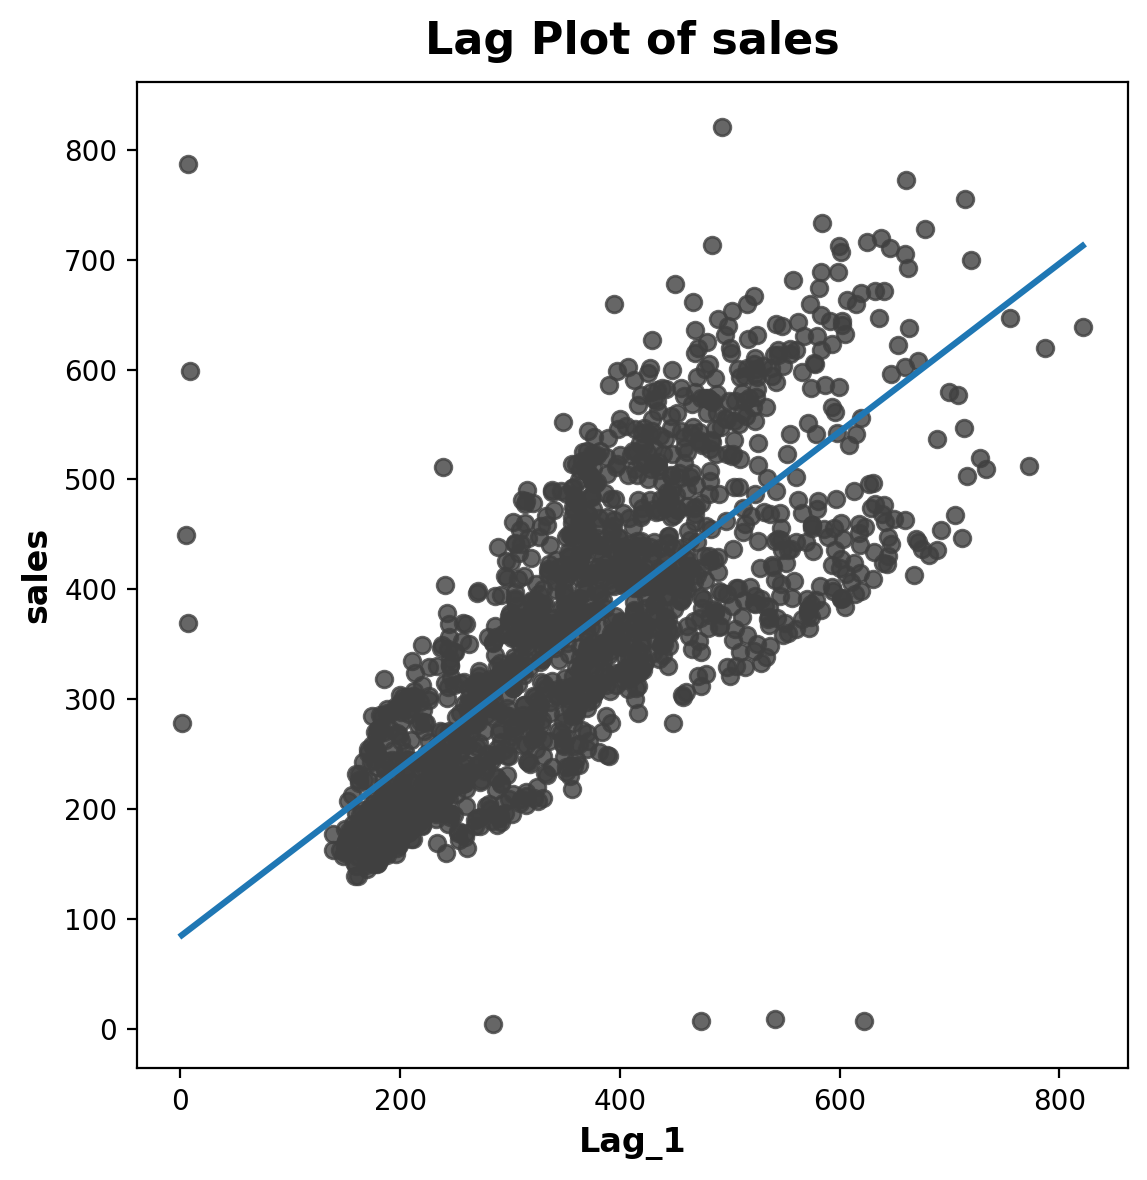

In [9]:
fig, ax = plt.subplots()
ax = sns.regplot(x = 'Lag_1', y = 'sales', data = avg_sales, ci = None, scatter_kws = dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of sales')

In [10]:
# linear regression

from sklearn.linear_model import LinearRegression

# Training data
X = avg_sales.loc[:, ['Time']] # features
y = avg_sales.loc[:, 'sales'] # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index = X.index)
# y_pred

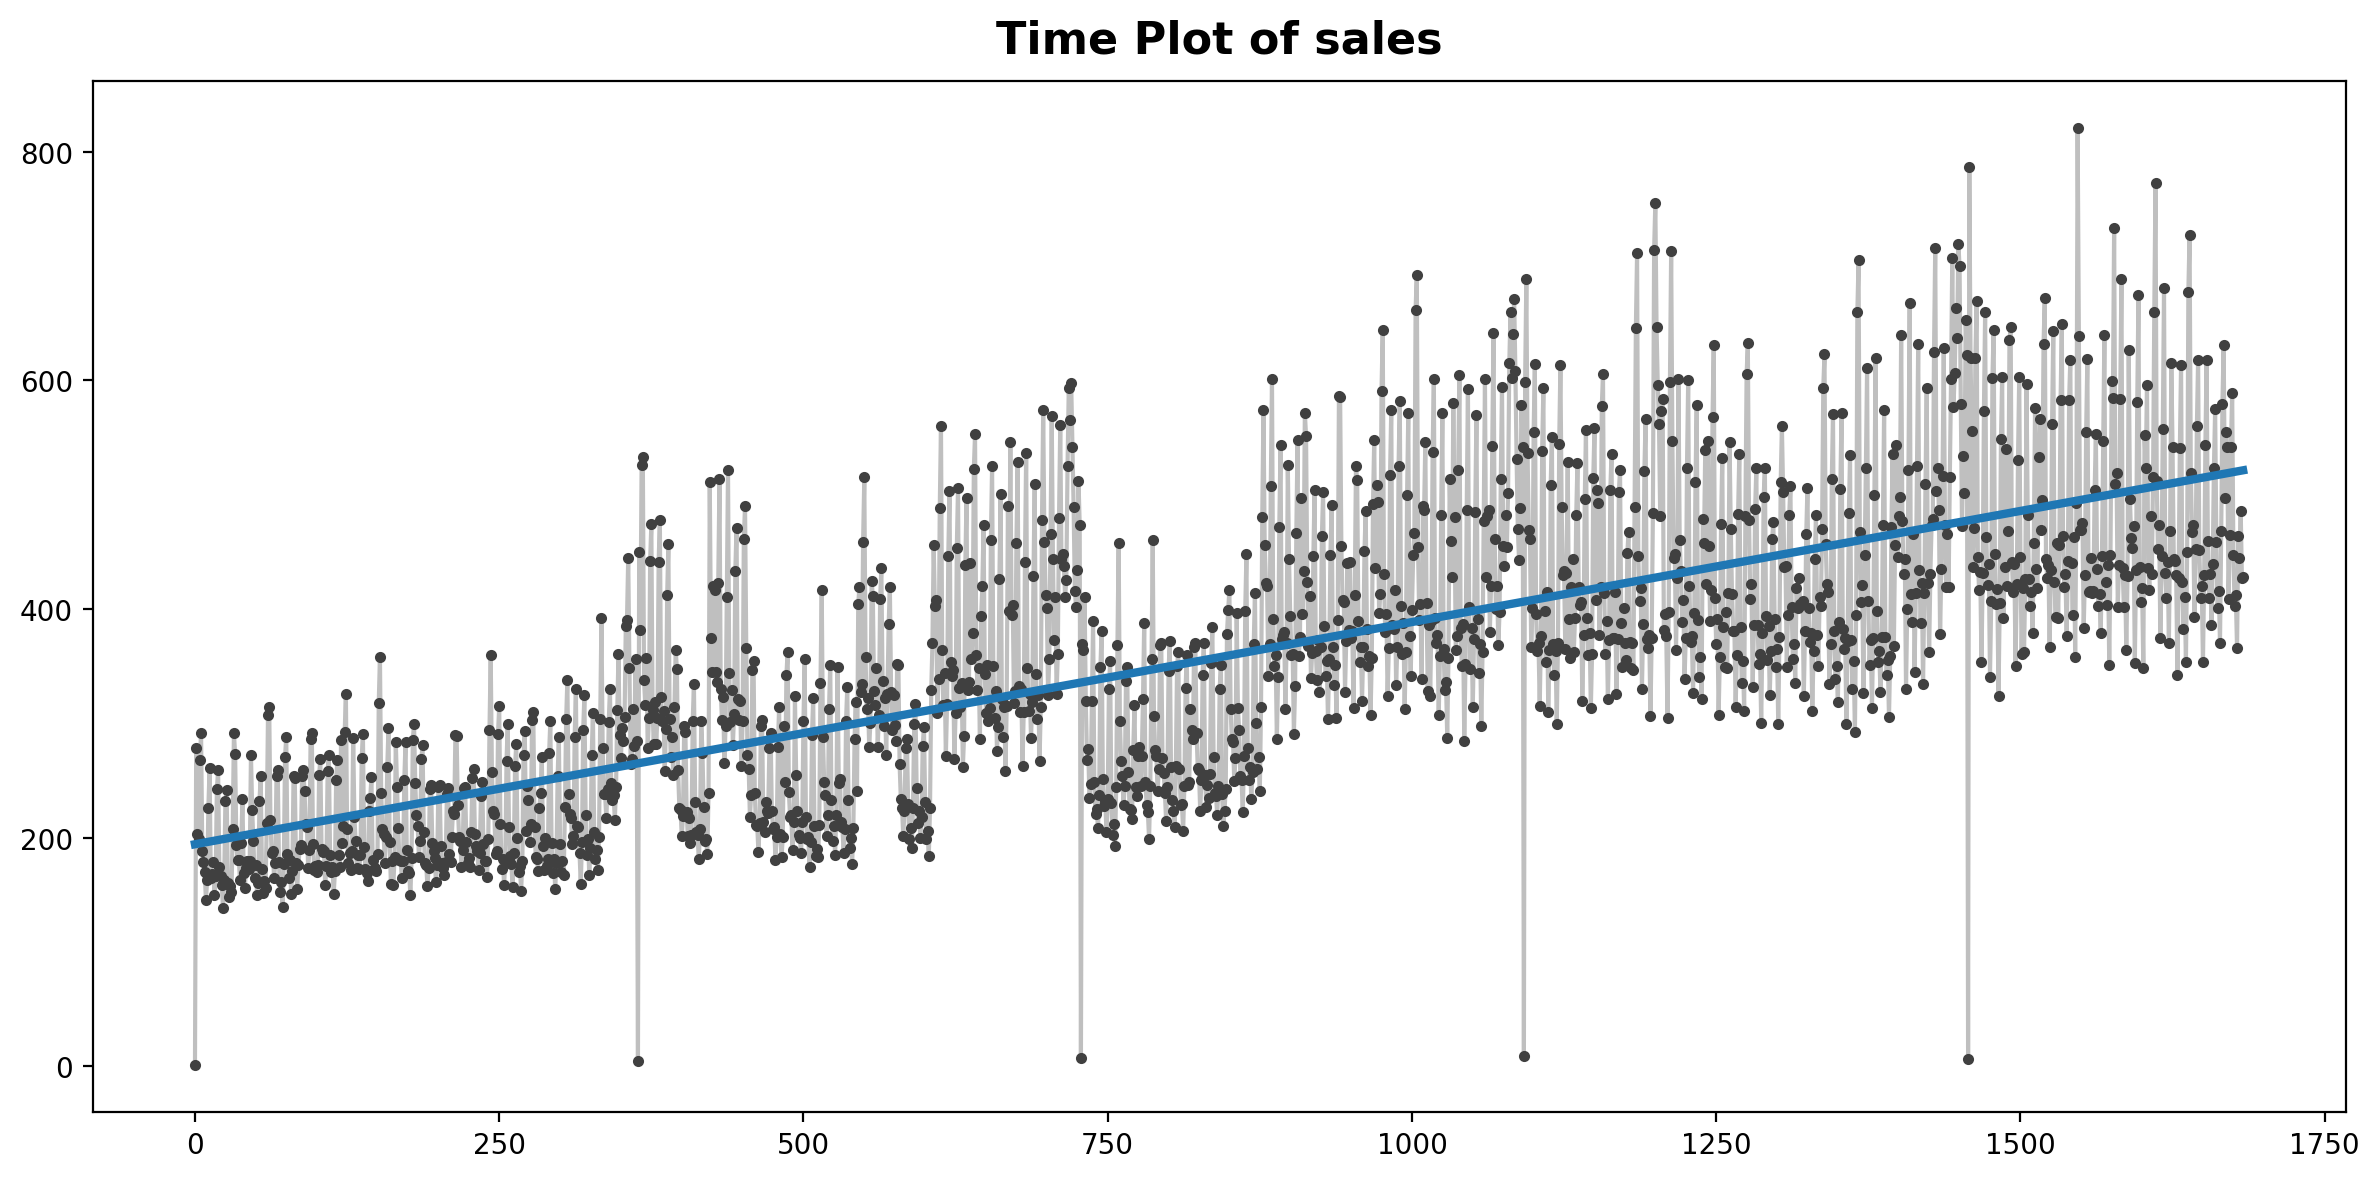

In [11]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of sales');

In [12]:
avg_sales.head()

,date,sales,Lag_1,Time
0,2013-01-01,1.409438,NaN,0
1,2013-01-02,278.390807,1.409438,1
2,2013-01-03,202.840197,278.390807,2
3,2013-01-04,198.911154,202.840197,3
4,2013-01-05,267.873244,198.911154,4


In [13]:
# Lag feature

from sklearn.linear_model import LinearRegression

X = avg_sales.loc[:, ['Lag_1']]
X.dropna(inplace = True) # drop missing values in the feature set
y = avg_sales.loc[:, 'sales'] # create the target
y, X = y.align(X, join = 'inner') # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
# y_pred

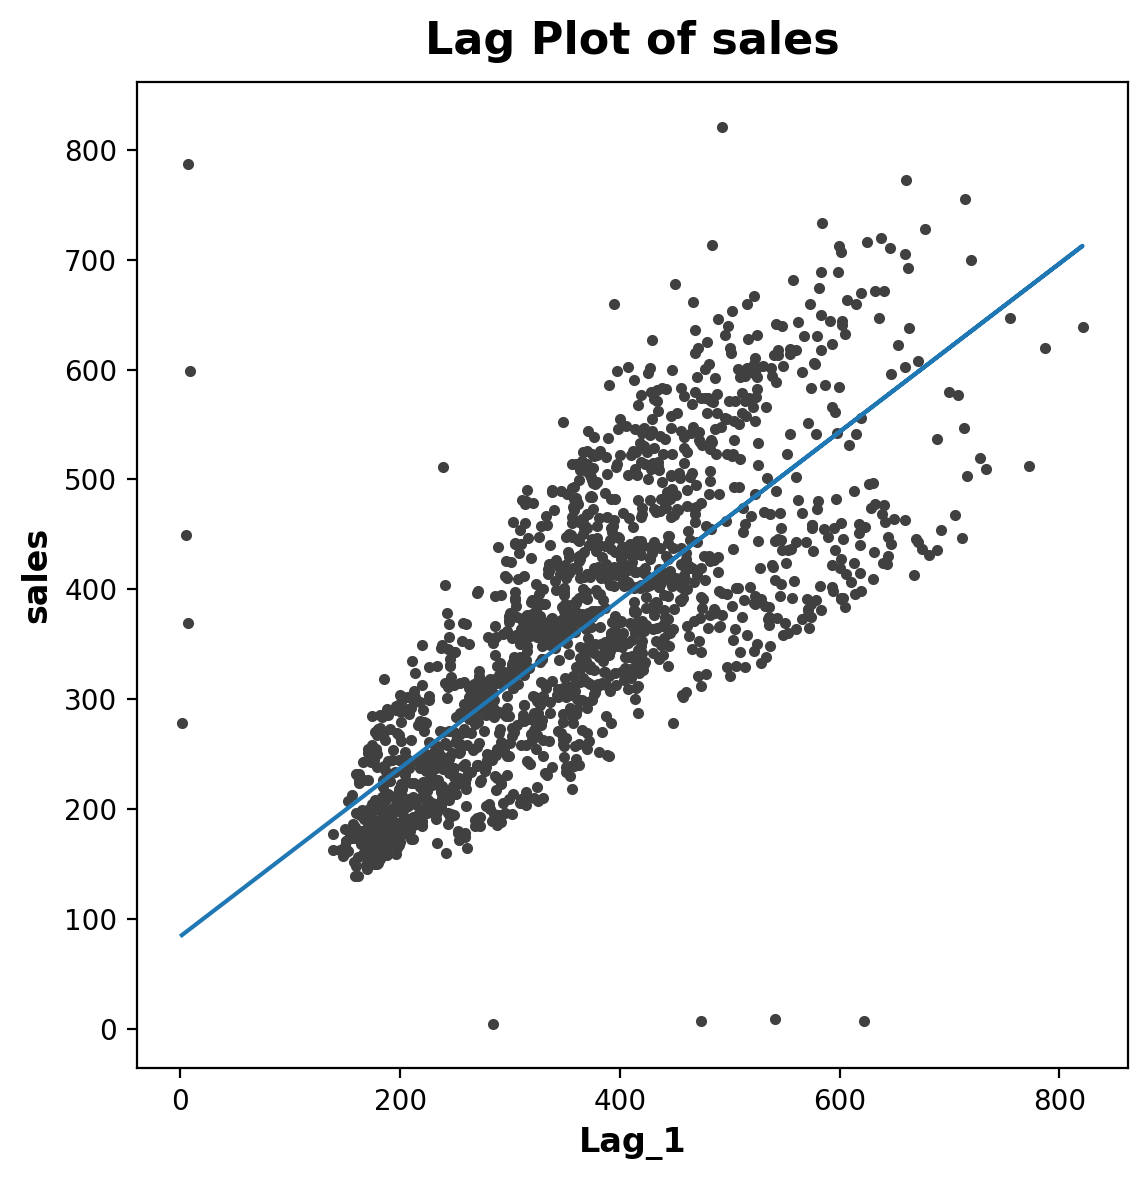

In [14]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of sales');

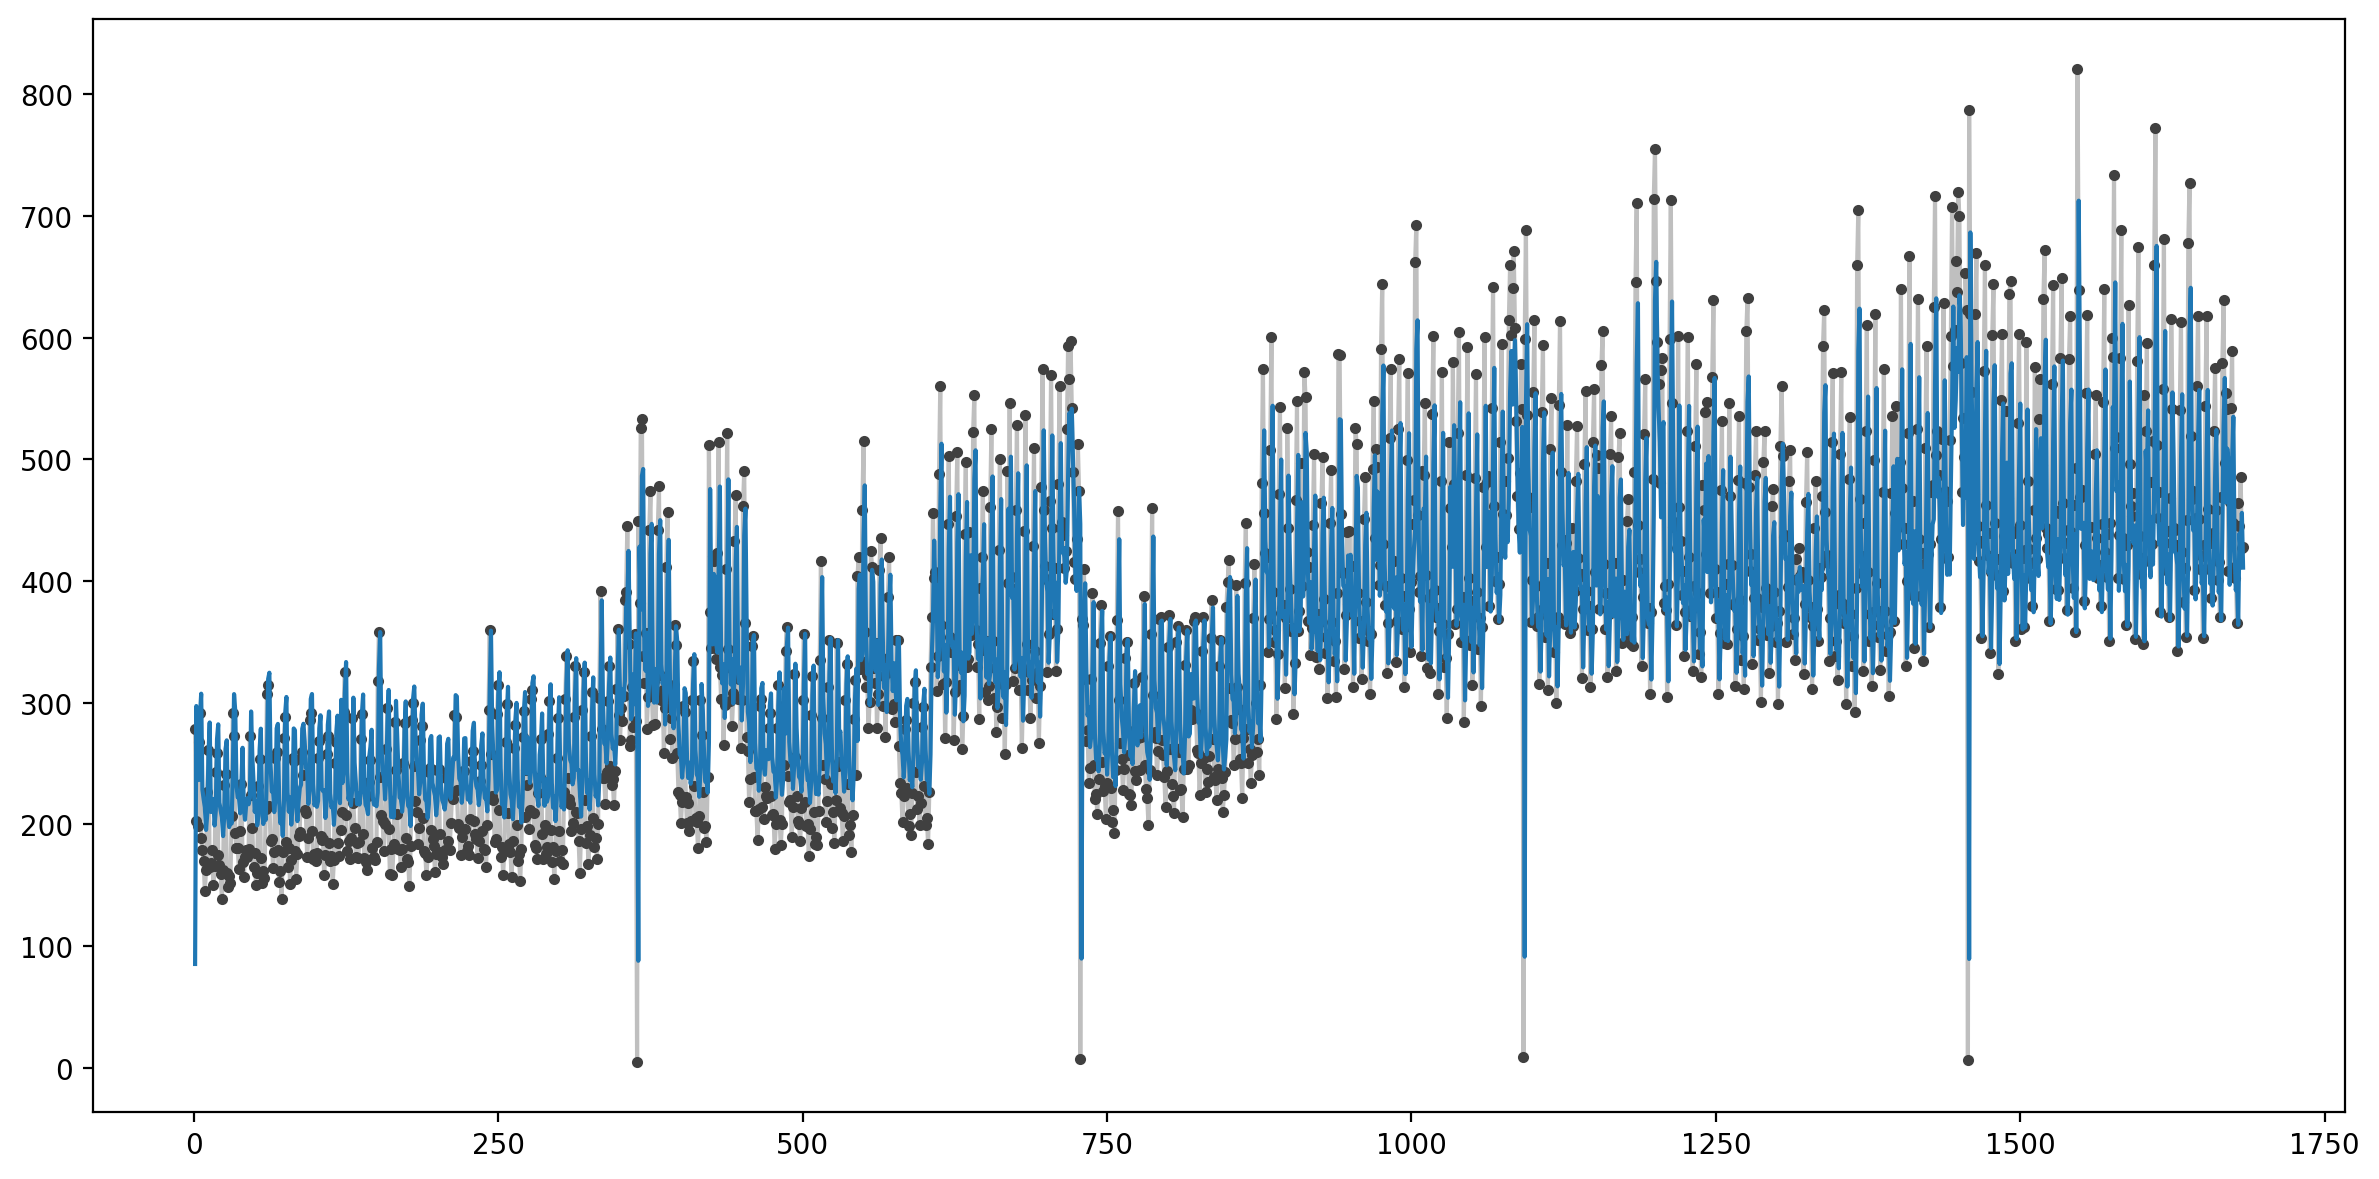

In [15]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

## 2. Trend

In [25]:
from pathlib import Path
from warnings import simplefilter

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Load the sales dataset
avg_sales = df_train.groupby('date').agg({'sales': 'mean'}).reset_index()
print(avg_sales["date"].dtype)
avg_sales = avg_sales.set_index('date')

# Ensure index is DatetimeIndex before using to_period
avg_sales.index = pd.to_datetime(avg_sales.index)
avg_sales = avg_sales.to_period("D")
#avg_sales.index = pd.to_datetime(avg_sales.index)
# avg_sales = avg_sales.set_index('date').to_period("D")
avg_sales.head()
# avg_sales.info()

object


,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


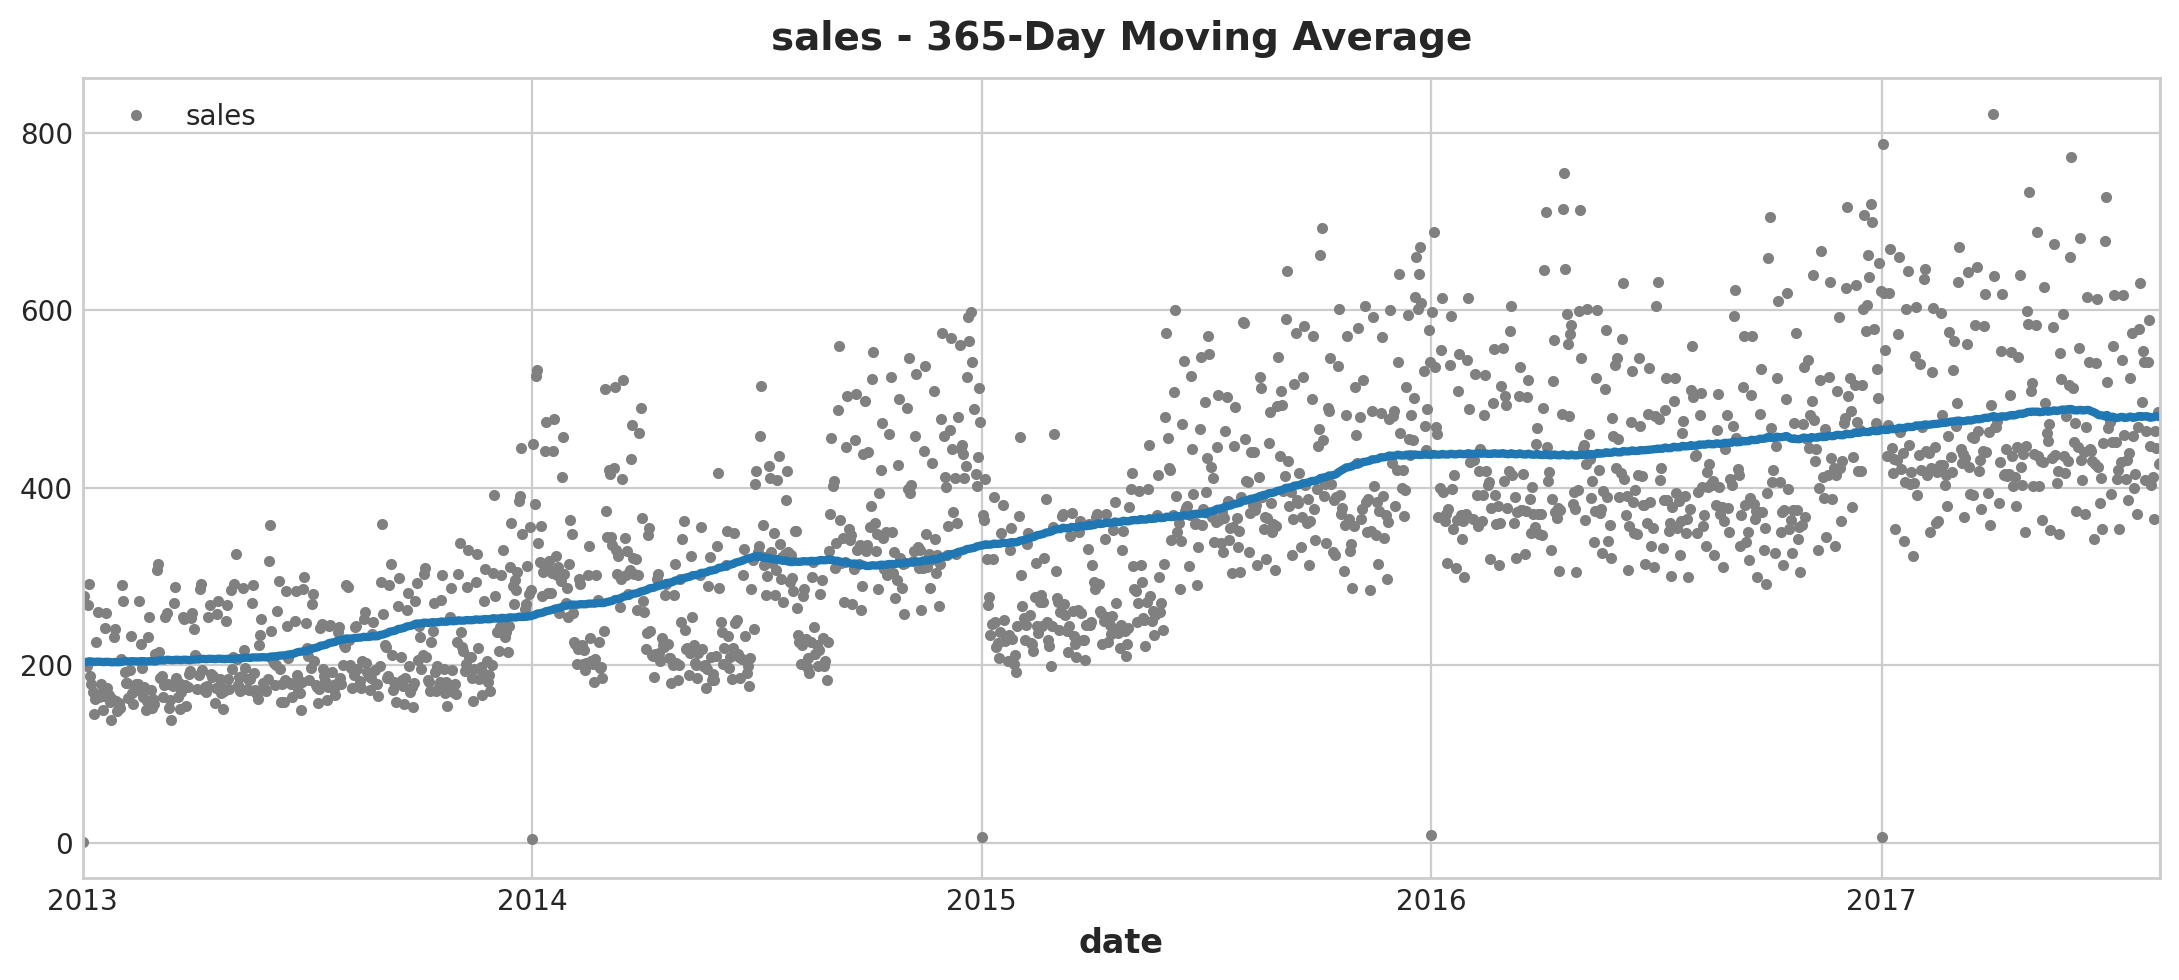

In [26]:
moving_average = avg_sales.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = avg_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="sales - 365-Day Moving Average", legend=False,
);

In [27]:
# trend feature

from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=avg_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


In [28]:
from sklearn.linear_model import LinearRegression
y = avg_sales["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

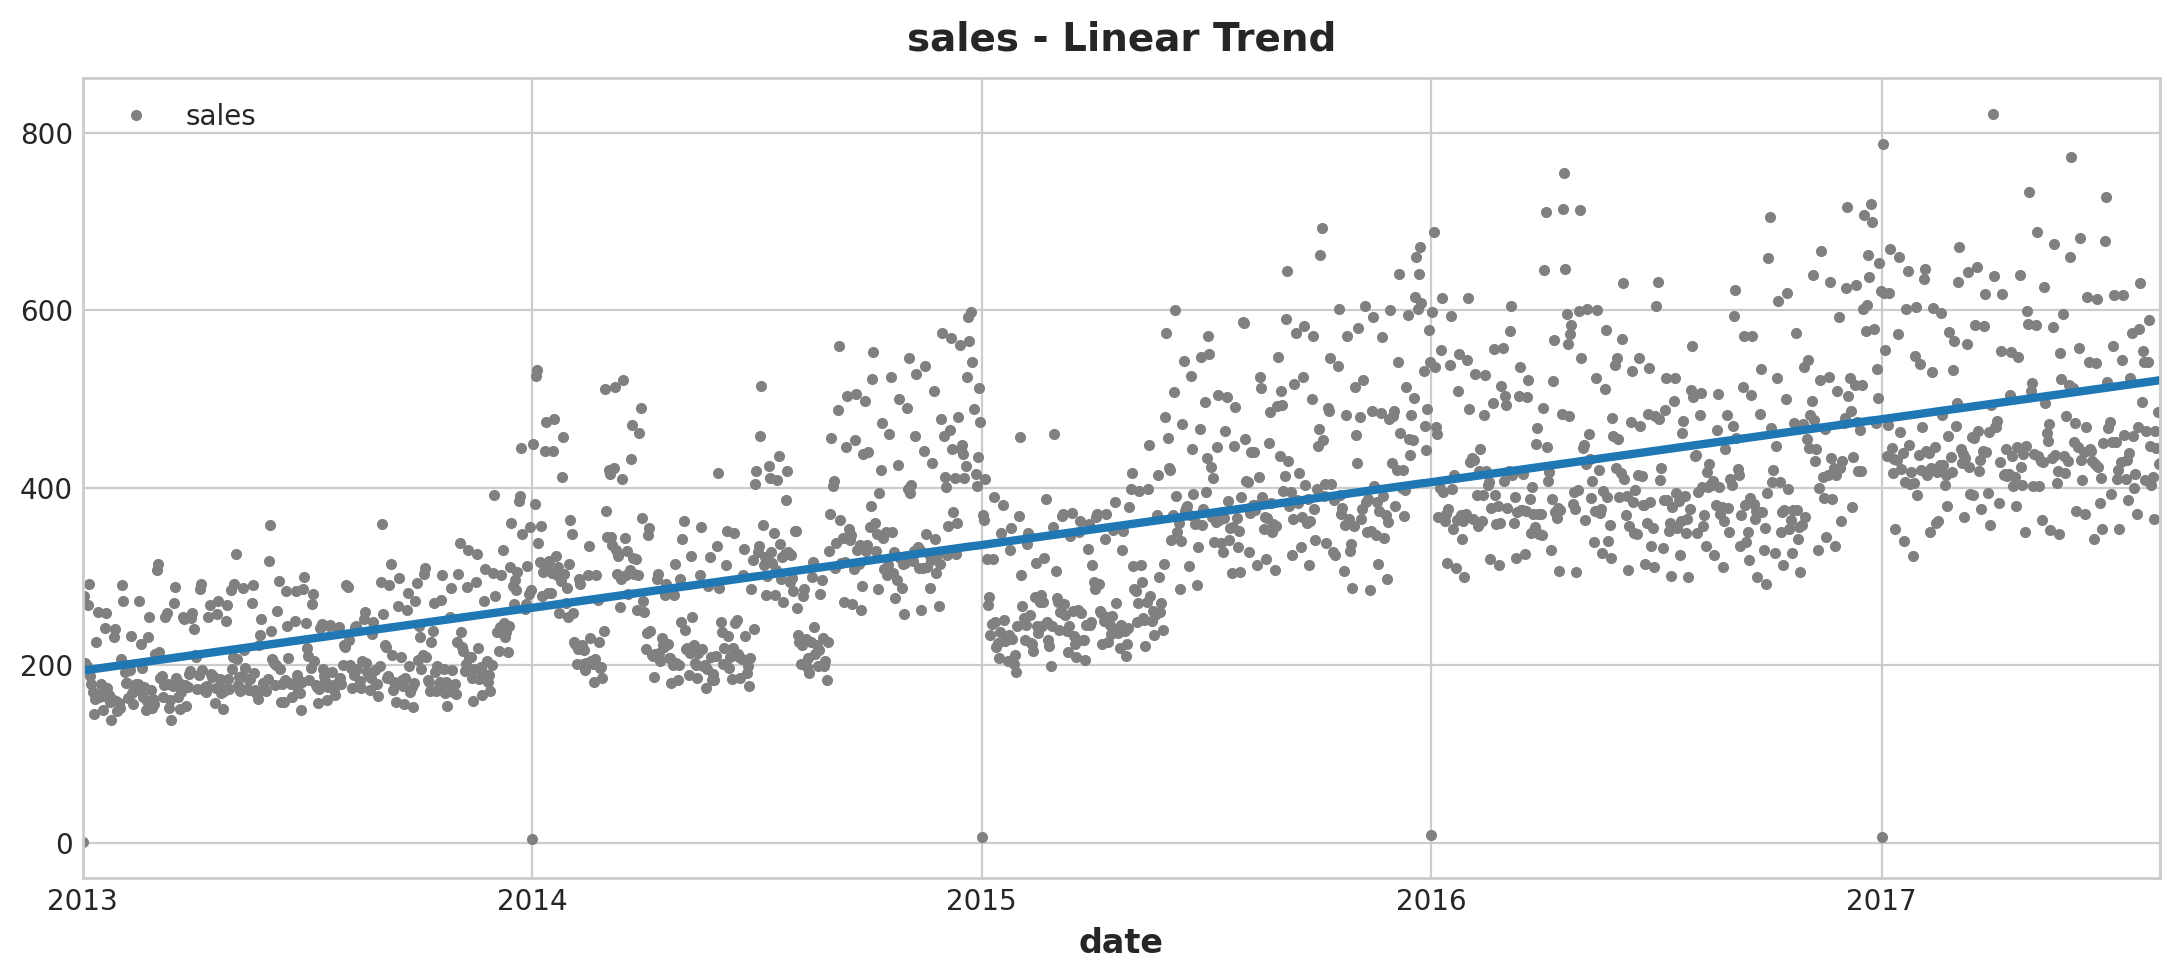

In [29]:
ax = avg_sales.plot(style=".", color="0.5", title="sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [40]:
X = dp.out_of_sample(steps=90) # 90 days after train data

y_fore = pd.Series(model.predict(X), index=X.index)

print(y_fore)

2017-08-16    521.513055
2017-08-17    521.707402
2017-08-18    521.901749
2017-08-19    522.096096
2017-08-20    522.290443
                 ...    
2017-11-09    538.032546
2017-11-10    538.226893
2017-11-11    538.421240
2017-11-12    538.615587
2017-11-13    538.809934
Freq: D, Length: 90, dtype: float64


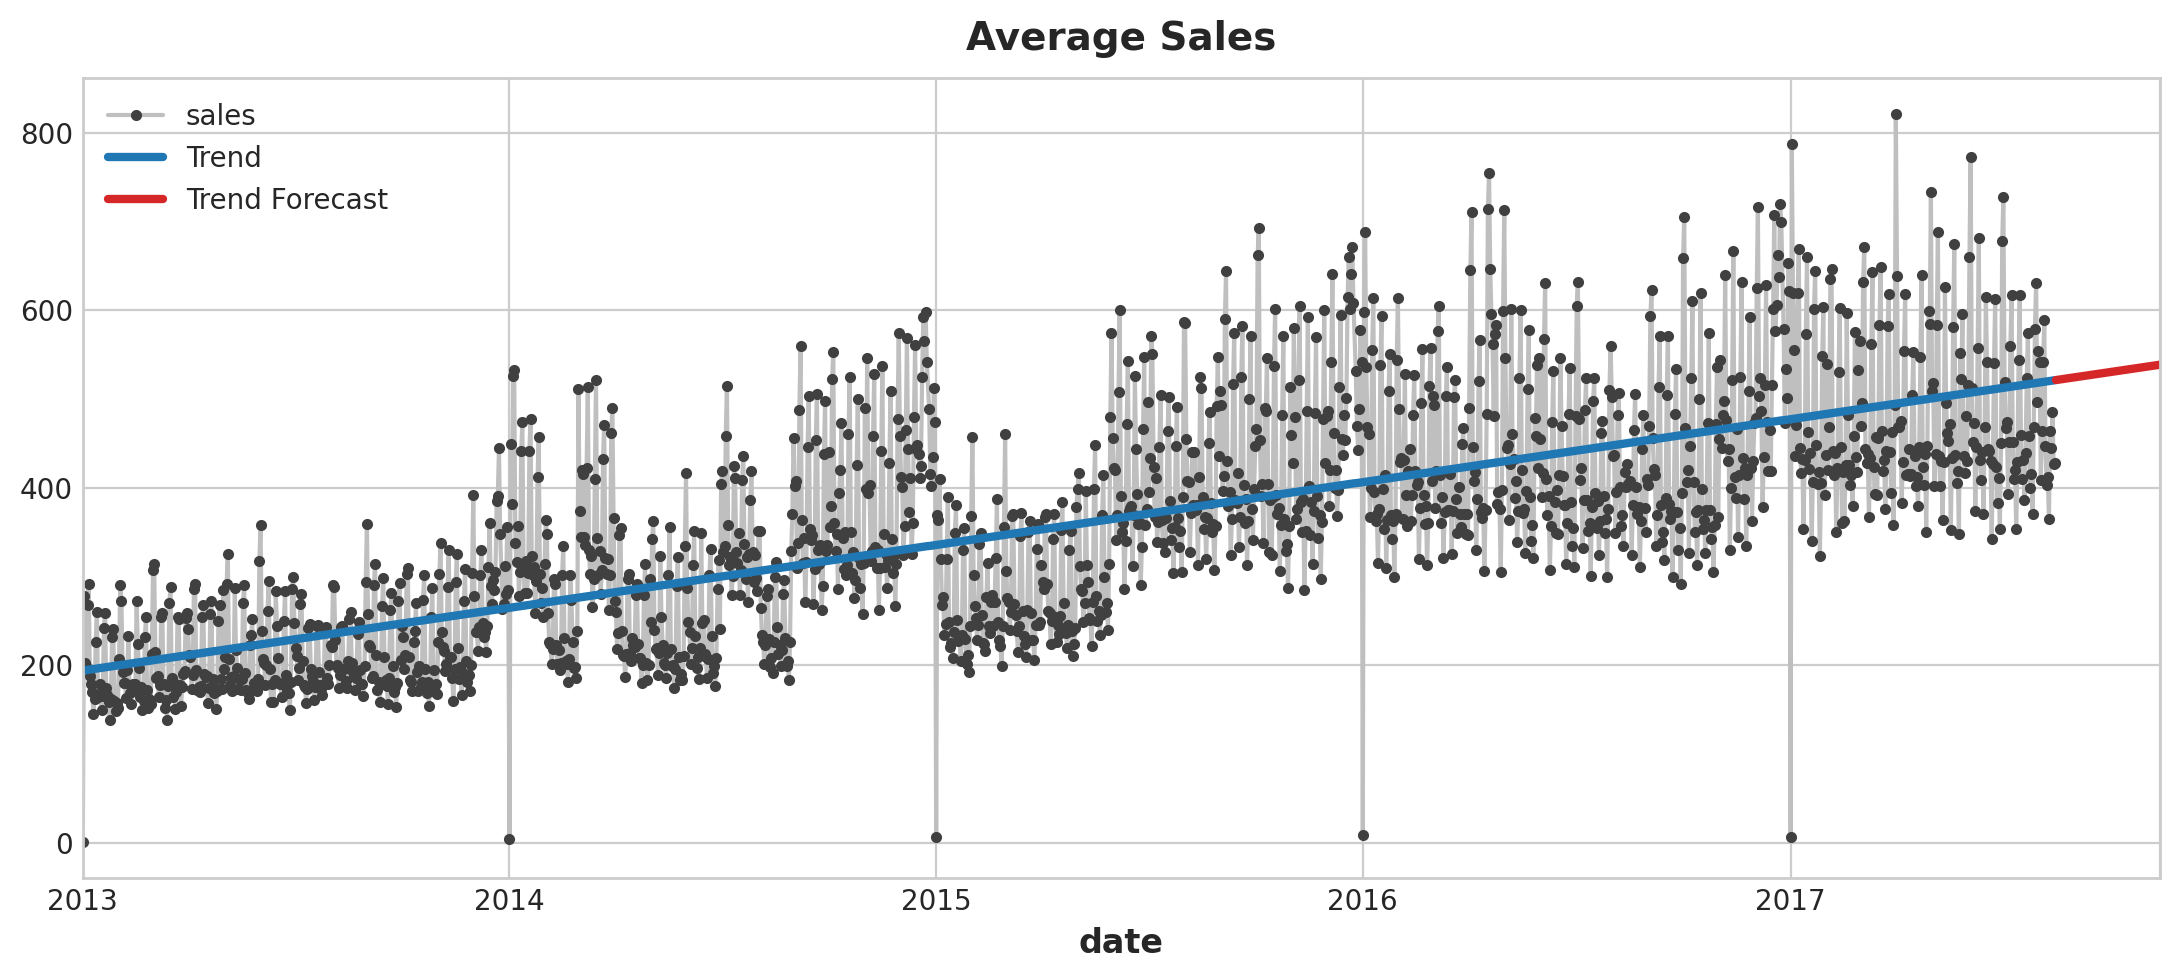

In [41]:
ax = avg_sales["2013-01":].plot(title="Average Sales", **plot_params)
ax = y_pred["2013-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Seasonality (imcomplete)

Two kinds of features that model seasonality.

The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations.

The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

In [44]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

# Load the sales dataset
avg_sales = df_train.groupby('date').agg({'sales': 'mean'}).reset_index()
avg_sales = avg_sales.set_index('date')
avg_sales.index = pd.to_datetime(avg_sales.index)
avg_sales = avg_sales.to_period("D")

avg_sales.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


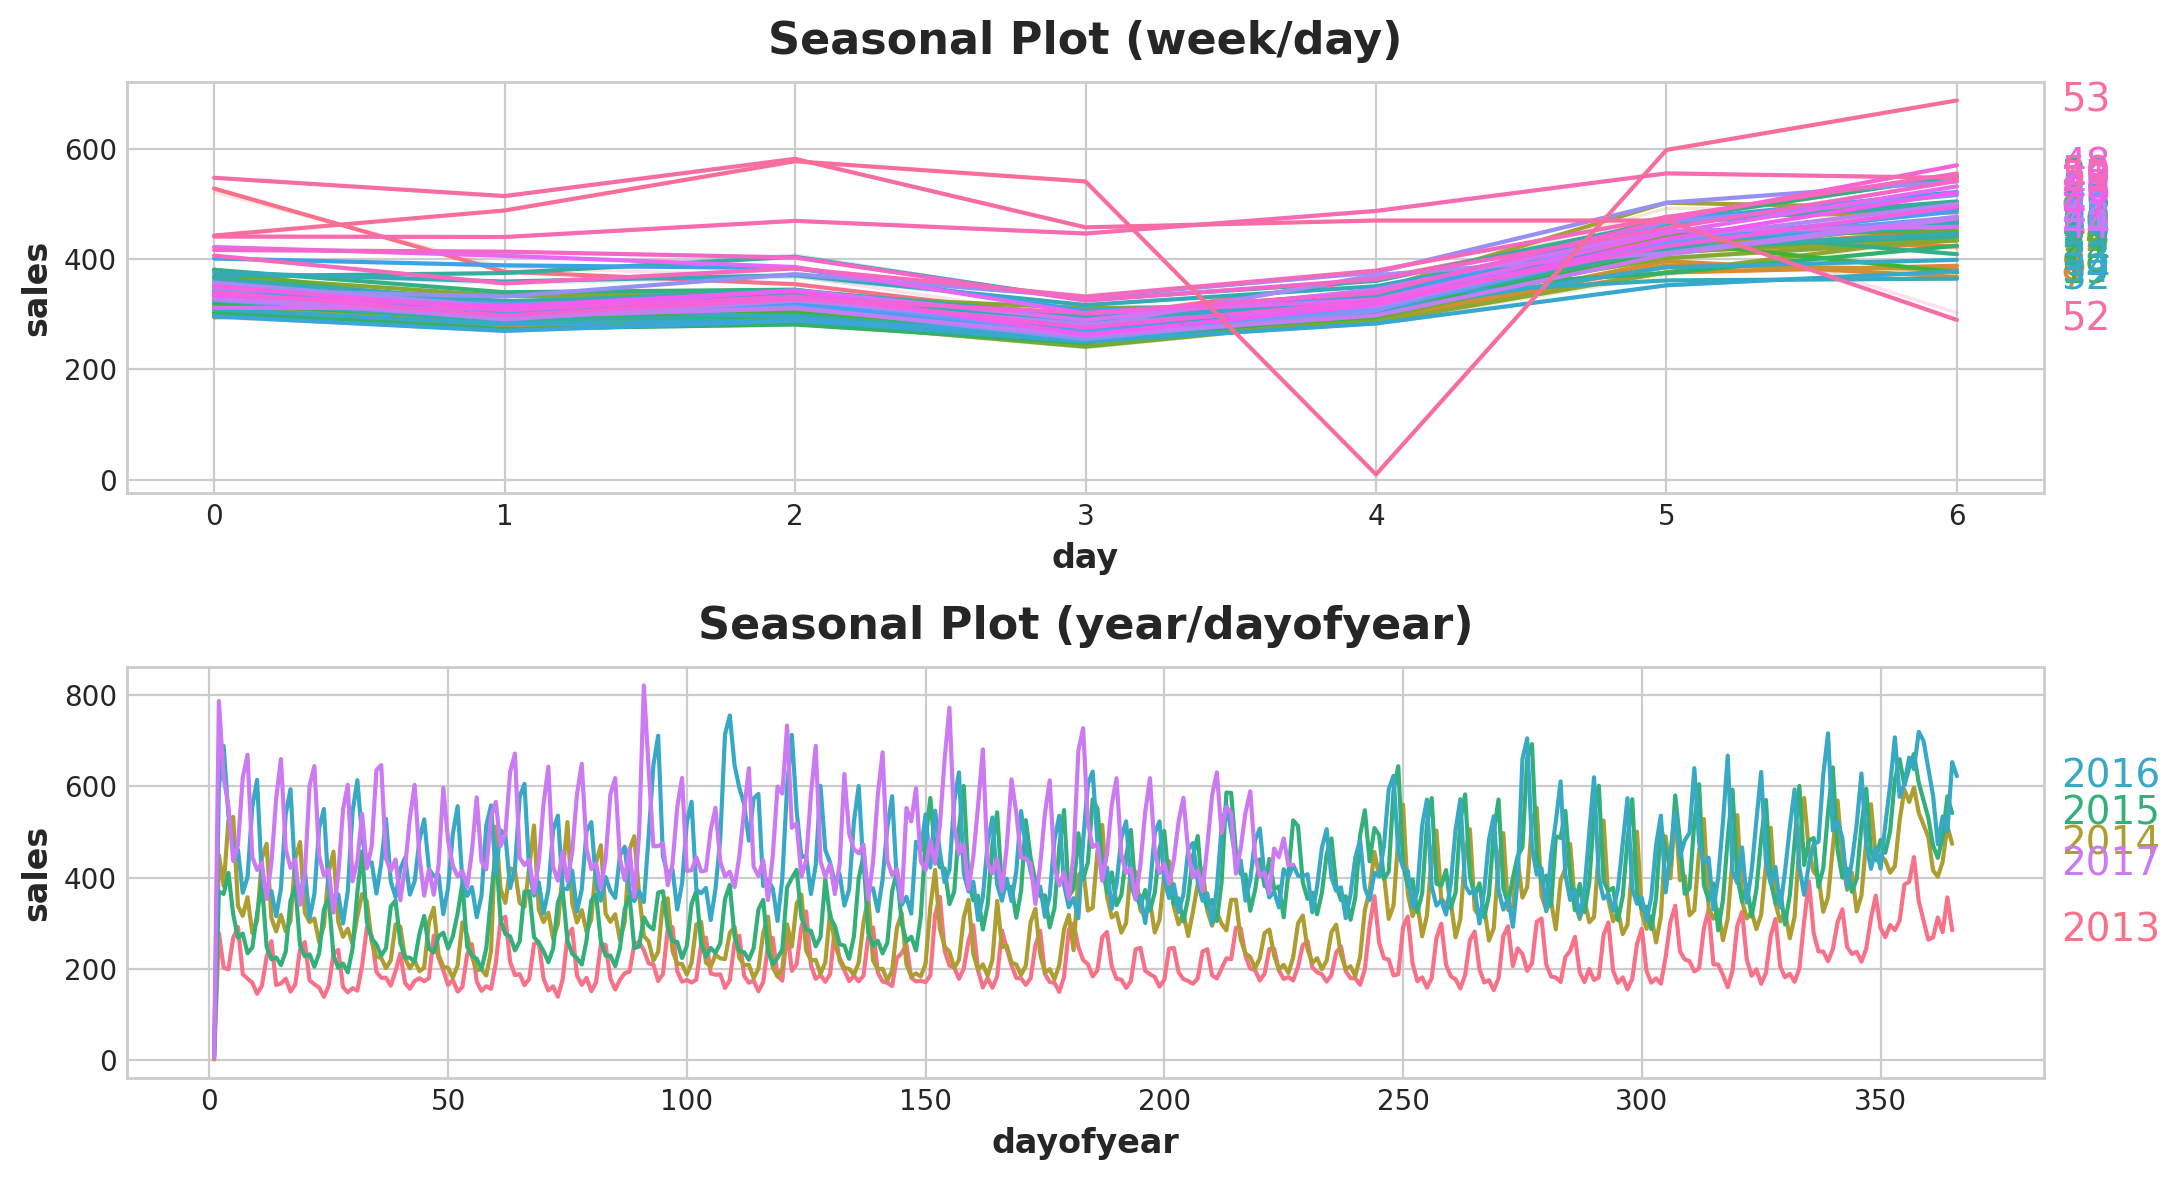

In [46]:
X = avg_sales.copy()

# days within a week
X['day'] = X.index.dayofweek # the x-axis (freq)
X['week'] = X.index.week # the seasonal period (period)

# days within a year
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

In [49]:
print(avg_sales.head())
print(avg_sales.tail())

                 sales
date                  
2013-01-01    1.409438
2013-01-02  278.390807
2013-01-03  202.840197
2013-01-04  198.911154
2013-01-05  267.873244
                 sales
date                  
2017-08-11  463.733851
2017-08-12  444.798280
2017-08-13  485.768618
2017-08-14  427.004717
2017-08-15  427.980884


ValueError: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and are not supported.

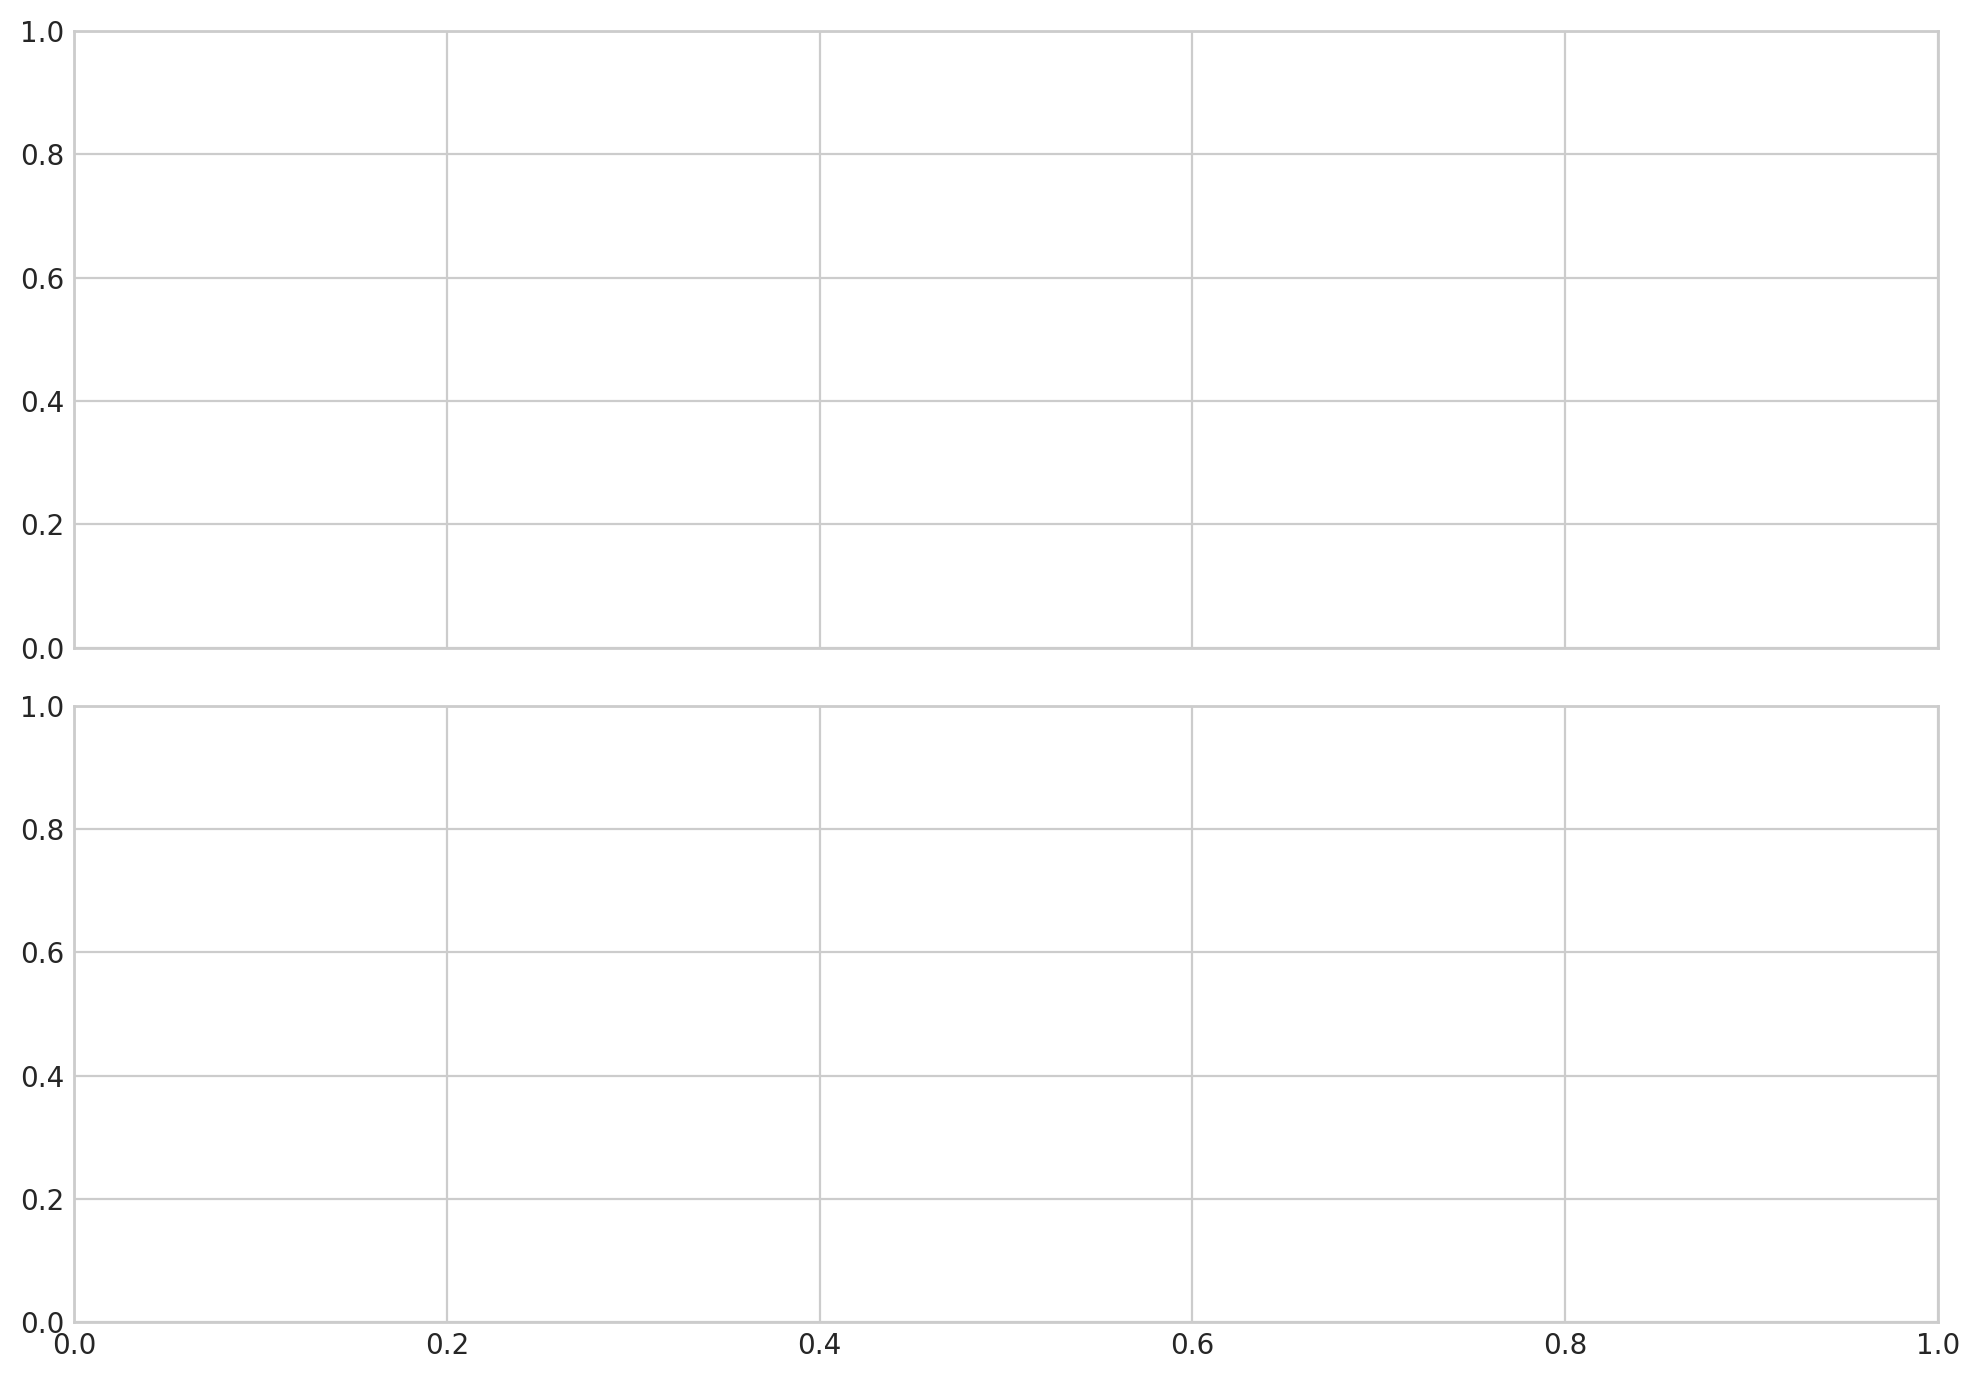

In [50]:
#plot_periodogram(avg_sales.sales);

y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

## Time Series as Features

### Cycles

What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality.

### Lagged Series and Lag Plots

partial autocorrelation <br>
cerrelogram (essentially what the periodogram is for Furier features) <br>
autocorrelation and partial autocorrelation are measures of linear dependence. Non-linear relationships can either be transformed to be linear or else learned by an appropriate algorithm.

fundamental limitation of using lagged features in time series forecasting: Lagged features are values from previous time steps (e.g., yesterday’s value to predict today’s value). While these features can be powerful for making predictions, they restrict us to forecasting only those time steps for which the necessary historical data (lagged values) are available.

In [14]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads

from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

comp_dir = Path('../input/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)



store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [15]:
mag_sales.head()

,sales,onpromotion
family,MAGAZINES,MAGAZINES
date,,
2017-01-01,0.074074,0.0
2017-01-02,7.777778,0.0
2017-01-03,3.500000,0.0
2017-01-04,3.500000,0.0
2017-01-05,3.203704,0.0


Text(0.5, 1.0, 'Magazine Sales (deseasonalized)')

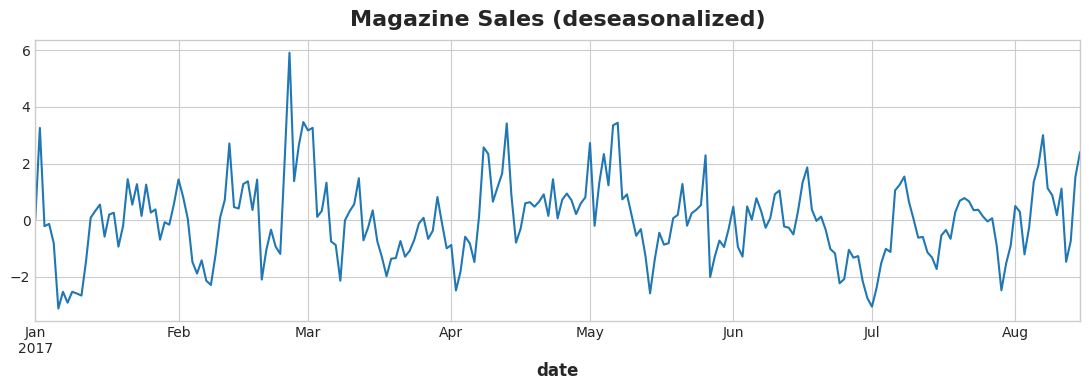

In [16]:
# deseasonalize Magazines sales
mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']
y = mag_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Magazine Sales (deseasonalized)")

In [17]:
y.head()

date
2017-01-01    0.074074
2017-01-02    7.777778
2017-01-03    3.500000
2017-01-04    3.500000
2017-01-05    3.203704
Freq: D, Name: MAGAZINES, dtype: float32

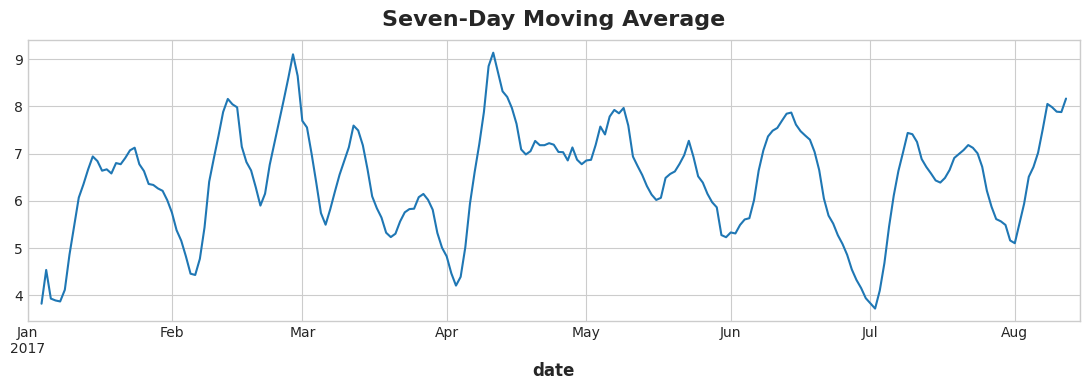

In [18]:
# 1) plotting cycles
# Create a seven-day moving average from y, the series of supply sales.
# Use a centered window, but don't set the min_periods argument.
y_ma = y.rolling(7, center=True).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

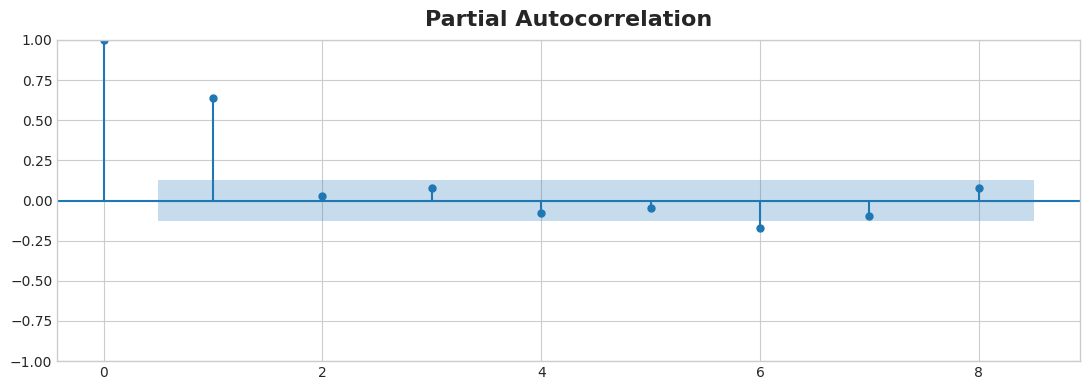

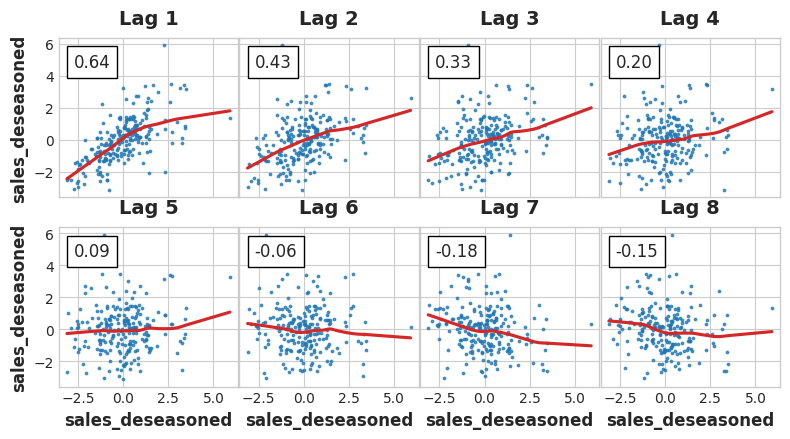

In [19]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

In [ ]:
onpromotion = mag_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop the New Year outlier
plot_lags(x=onpromotion.iloc[1:], y=y_deseason.iloc[1:], lags=3, leads=3, nrows=1);

In [ ]:
# YOUR CODE HERE: Make features from `y_deseason`
X_lags = make_lags(y_deseason, lags = 1)

# YOUR CODE HERE: Make features from `onpromotion`
# You may want to use `pd.concat`
X_promo = pd.concat([
    make_lags(onpromotion, lags= 1),
    onpromotion,
    make_leads(onpromotion, leads = 1),
], axis=1)

# YOUR CODE HERE: Make features from `oil`
X_oil = pd.DataFrame()

X = pd.concat([X_lags, X_promo, X_oil], axis=1).dropna()
y, X = y.align(X, join='inner')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

In [ ]:
y_lag = mag_sales.loc[:, 'sales'].shift(1)
onpromo = mag_sales.loc[:, 'onpromotion']

# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# YOUR CODE HERE: 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# YOUR CODE HERE: 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# YOUR CODE HERE: 7-day sum of promotions with centered window
promo_7 = onpromo.rolling(7, center=True).sum()